In [113]:
#Import#

from cellpose import models, core, io, plot
import numpy as np
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from cellpose import train
from cellpose import metrics
import imageio.v2 as imageio
import os
import skimage.filters
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage import data, img_as_float
import pandas as pd
from glob import glob
from skimage.measure import regionprops
from scipy.spatial.distance import cdist
from skimage import exposure
from skimage.measure import regionprops
from scipy.ndimage import generate_binary_structure, binary_dilation

In [2]:
#Data input from the User

folder_path = r'Y:\Group Members\Valentin Aubry\01_Data\Test_Data_Andreas_hard'  # The r in r'Example' is very important

In [3]:
# High Throughput Data Loading
Cy5_data = glob(os.path.join(folder_path, '*Cy5 SEM.tif'))
DAPI_data = glob(os.path.join(folder_path, '*DAPI SEM.tif'))
DAPI_mask_data = glob(os.path.join(folder_path, '*DAPI SEM_seg.npy'))
FITC_data = glob(os.path.join(folder_path, '*FITC SEM.tif'))
TRITC_data = glob(os.path.join(folder_path, '*TRITC SEM.tif'))


# Sorting the data in case it isn't yet
Cy5_data.sort()
DAPI_data.sort()
DAPI_mask_data.sort()
FITC_data.sort()
TRITC_data.sort()


# Displaying all the data that was loaded
for i in range (len(DAPI_data)):
    print(os.path.basename(Cy5_data[i]))
    print(os.path.basename(DAPI_data[i]))
    print(os.path.basename(DAPI_mask_data[i]))
    print(os.path.basename(FITC_data[i]))
    print(os.path.basename(TRITC_data[i]))


ATR1_24h--W00032--P00015--Z00000--T00000--Cy5 SEM.tif
ATR1_24h--W00032--P00015--Z00000--T00000--DAPI SEM.tif
ATR1_24h--W00032--P00015--Z00000--T00000--DAPI SEM_seg.npy
ATR1_24h--W00032--P00015--Z00000--T00000--FITC SEM.tif
ATR1_24h--W00032--P00015--Z00000--T00000--TRITC SEM.tif
ATR1_8h--W00029--P00035--Z00000--T00000--Cy5 SEM.tif
ATR1_8h--W00029--P00035--Z00000--T00000--DAPI SEM.tif
ATR1_8h--W00029--P00035--Z00000--T00000--DAPI SEM_seg.npy
ATR1_8h--W00029--P00035--Z00000--T00000--FITC SEM.tif
ATR1_8h--W00029--P00035--Z00000--T00000--TRITC SEM.tif
ATR1_UT--W00026--P00005--Z00000--T00000--Cy5 SEM.tif
ATR1_UT--W00026--P00005--Z00000--T00000--DAPI SEM.tif
ATR1_UT--W00026--P00005--Z00000--T00000--DAPI SEM_seg.npy
ATR1_UT--W00026--P00005--Z00000--T00000--FITC SEM.tif
ATR1_UT--W00026--P00005--Z00000--T00000--TRITC SEM.tif
ATR2_24h--W00044--P00021--Z00000--T00000--Cy5 SEM.tif
ATR2_24h--W00044--P00021--Z00000--T00000--DAPI SEM.tif
ATR2_24h--W00044--P00021--Z00000--T00000--DAPI SEM_seg.npy
ATR2_

In [11]:
#High Throughput Data Loading Loop
for i in range (len(DAPI_data)):
    #Loading the picture on i position from each channel
    Cy5_pic = imageio.imread(Cy5_data[i])
    DAPI_pic = imageio.imread(DAPI_data[i])
    DAPI_mask_pic = np.load(DAPI_mask_data[i], allow_pickle=True).item()
    FITC_pic = imageio.imread(FITC_data[i])
    TRITC_pic = imageio.imread(TRITC_data[i])

    # Extract the name of the picture that will be analyzed to later be able to save it accordingly
    base_name = os.path.basename(DAPI_data[i]).removesuffix('DAPI SEM.tif')

    # Extract the actual mask array
    masks = DAPI_mask_pic['masks']  # This contains the segmented regions

    # Function to generate a picture for every cell that cellpose recognized
    for j in range (1,len(np.unique(masks))):
        
        # Defining which nucleus from the Segmentation Mask is isolated
        cellnumber = j
        masks_reduced = (masks == cellnumber)  
    
        # Overlaying DAPI mask to TRITC
        masked_TRITC = np.ma.masked_where(masks_reduced == 0, masks_reduced)  
    
        # Applying the mask to the TRITC picture by setting the background to 0 (black)
        isolated_TRITC = TRITC_pic.copy()  # copying the original picture so that it doesn't get changed
        isolated_TRITC[masks_reduced==False] = 0  # assign the pixels from the TRITC picture copy the value 0 (black), where the mask has the value false (background)
        
        # Applying a difference of gaussian filter on the picture --> enhances peaks and smooths out background
        filtered_TRITC = skimage.filters.difference_of_gaussians(isolated_TRITC, 1, high_sigma=None, mode='nearest', cval=0, channel_axis=None, truncate=4.0)

        # conversion of integer pixel values to float
        filt_img_float = img_as_float(filtered_TRITC)

        # Detecting the coordinates of the peaks
        coordinates = peak_local_max(
            filt_img_float, 
            min_distance=2,
            threshold_rel=0.25      # Only peaks above X% of brightest pixel in this picture
            # OR
            #threshold_abs=0.2       # Only peaks above X% of absolute brightest picture (not relative to the brightest pixel in the picture)
        )

        #Saving the peaks in a .csv file
        #Creating a .csv file containing all the coordinates of foci labbeled with each cell
        foci_data = pd.DataFrame(data=coordinates, columns=['y', 'x'])
        foci_data['cell_number'] = cellnumber



        # Praparing arguments for saving the data in a .csv
        header = False # So it doesn't add a header unless j=1
        mode = 'a'  # so it adds to an existing file that was created with the first analyzed cell at j=1
        
        if j == 1:
            header = True  # To add a header when creating the file
            mode = 'w'  # Standard mode (not adding to a file)

    

        #To add to an existing .csv file without adding headers
        foci_data.to_csv(folder_path+'/'+base_name+'DF SEM.csv', mode=mode, header=header, index=False)

In [147]:
print(os.path.basename(TRITC_data[5]))

ATR2_UT--W00038--P00017--Z00000--T00000--TRITC SEM.tif


In [ ]:
# 5--> 58, 75, 93

In [43]:
print(len(np.unique(masks)))

126


In [134]:
picture_number = 5
cell_number = 93


#High Throughput Data Loading Loop
#for i in range (len(DAPI_data)):
i = picture_number

#Loading the picture on i position from each channel
Cy5_pic = imageio.imread(Cy5_data[i])
DAPI_pic = imageio.imread(DAPI_data[i])
DAPI_mask_pic = np.load(DAPI_mask_data[i], allow_pickle=True).item()
FITC_pic = imageio.imread(FITC_data[i])
TRITC_pic = imageio.imread(TRITC_data[i])

TRITC_pic = img_as_float(TRITC_pic)




almost_max = np.percentile(TRITC_pic[TRITC_pic > 0], 99) # Gets the brightness of the 99th percentile of brightest pixels to reduce outliers

foci_distance_filt = 2
foci_threshold_filt = almost_max * 0.8

foci_distance_unfilt = 2
foci_threshold_unfilt = almost_max * 0.8

tolerance = 2  # Distance at which the detected foci in the gamma adjusted TRIC picture are confirmed if there is one also detected on the DoG picture




# Extract the name of the picture that will be analyzed to later be able to save it accordingly
base_name = os.path.basename(DAPI_data[i]).removesuffix('DAPI SEM.tif')

# Extract the actual mask array
masks = DAPI_mask_pic['masks']  # This contains the segmented regions

# Function to generate a picture for every cell that cellpose recognized
#for j in range (1,len(np.unique(masks))):
j = cell_number

# Defining which nucleus from the Segmentation Mask is isolated
cellnumber = j
masks_reduced = (masks == cellnumber)  

# Overlaying DAPI mask to TRITC
masked_TRITC = np.ma.masked_where(masks_reduced == 0, masks_reduced)  




# Applying the mask to the TRITC picture by setting the background to 0 (black)
isolated_TRITC = TRITC_pic.copy()  # copying the original picture so that it doesn't get changed
isolated_TRITC[masks_reduced==False] = 0  # assign the pixels from the TRITC picture copy the value 0 (black), where the mask has the value false (background)

#gamma_TRITC = skimage.exposure.adjust_gamma(isolated_TRITC, gamma=1)
#isolated_TRITC = exposure.rescale_intensity(isolated_TRITC, in_range='image', out_range=(0, isolated_TRITC.max()))


# Applying a difference of gaussian filter on the picture --> enhances peaks and smooths out background
filtered_TRITC = skimage.filters.difference_of_gaussians(isolated_TRITC, low_sigma=1, high_sigma=5, mode='nearest', cval=0, channel_axis=None, truncate=4.0)
filtered_TRITC = np.clip(filtered_TRITC, 0, None)

#filtered_TRITC = skimage.exposure.adjust_gamma(filtered_TRITC, gamma=1)
filtered_TRITC = exposure.rescale_intensity(filtered_TRITC, in_range='image', out_range=(0, isolated_TRITC.max()))


# Detecting the coordinates of the peaks
coordinates_filtered = peak_local_max(
    filtered_TRITC, 
    min_distance=foci_distance_filt,        # This is just the minimal distance of how close two foci can be detected next to eachother
    threshold_abs=foci_threshold_filt       # Only peaks above X% of absolute brightest picture (not relative to the brightest pixel in the picture)
)

# Detecting the coordinates of the peaks
coordinates_unfiltered = peak_local_max(
    isolated_TRITC, 
    min_distance=foci_distance_unfilt,        # This is just the minimal distance of how close two foci can be detected next to eachother
    threshold_abs=foci_threshold_unfilt       # Only peaks above X% of absolute brightest picture (not relative to the brightest pixel in the picture)
)

def local_contrast(image, coordinates, contrast_threshold=2.5):
    confirmed_coords = []  #Empty array to store the filtered coordinates in later
    for i in coordinates:
        y, x = i   # Get the coordinates for each foci 
        y_min, y_max = max(0, y-5), min(image.shape[0], y+6)  #setting boudaries from y-5 to y+5(Y+6 gets excluded as upper border)
        x_min, x_max = max(0, x-5), min(image.shape[1], x+6)
        square = image[y_min:y_max, x_min:x_max]  #creating a square with the defined boudaries

        potential_foci = image[y, x]
        local_background = np.percentile(square, 25)  # Selects a pixel with the brightness in the defined percentage for comparison

        if potential_foci > local_background * contrast_threshold:  # If the potential foci is X-times brighter than the selected background, the foci is confirmed
            confirmed_coords.append(i)
            
    # returns the confirmed foci coordinates or if there are none creates an empty array to not crash the display below
    return np.array(confirmed_coords) if confirmed_coords else np.array([]).reshape(0, 2)
    
# Running the above defined function on the filtered and unfiltered coordinates
coordinates_unfiltered = local_contrast(isolated_TRITC, coordinates_unfiltered)
coordinates_filtered = local_contrast(filtered_TRITC, coordinates_filtered)


# Find foci that are close in both sets (within tolerance distance)
distances = cdist(coordinates_unfiltered, coordinates_filtered)  # calculate the distance between filtered foci and unfiltered foci
tolerance = tolerance  # pixels of how far apart the foci maximally can be on both pictures to be confirmed


if coordinates_unfiltered.size > 0 and coordinates_filtered.size > 0:
    # Keep foci from unfiltered that have a match in filtered
    coordinates = coordinates_unfiltered[np.min(distances, axis=1) <= tolerance]  # np.min: find minimal distance between nearest foci, 
    #<=tolerance: creates a boolean array with true for each unfiltered foci with a filtered one within tolerance, 
    #coordinates_unfiltered[]: keeps only foci that are True
else:
    coordinates = np.array([]).reshape(0, 2)  #generating an epmty array, so that the visualization down below doesn't get an error if no foci was detected












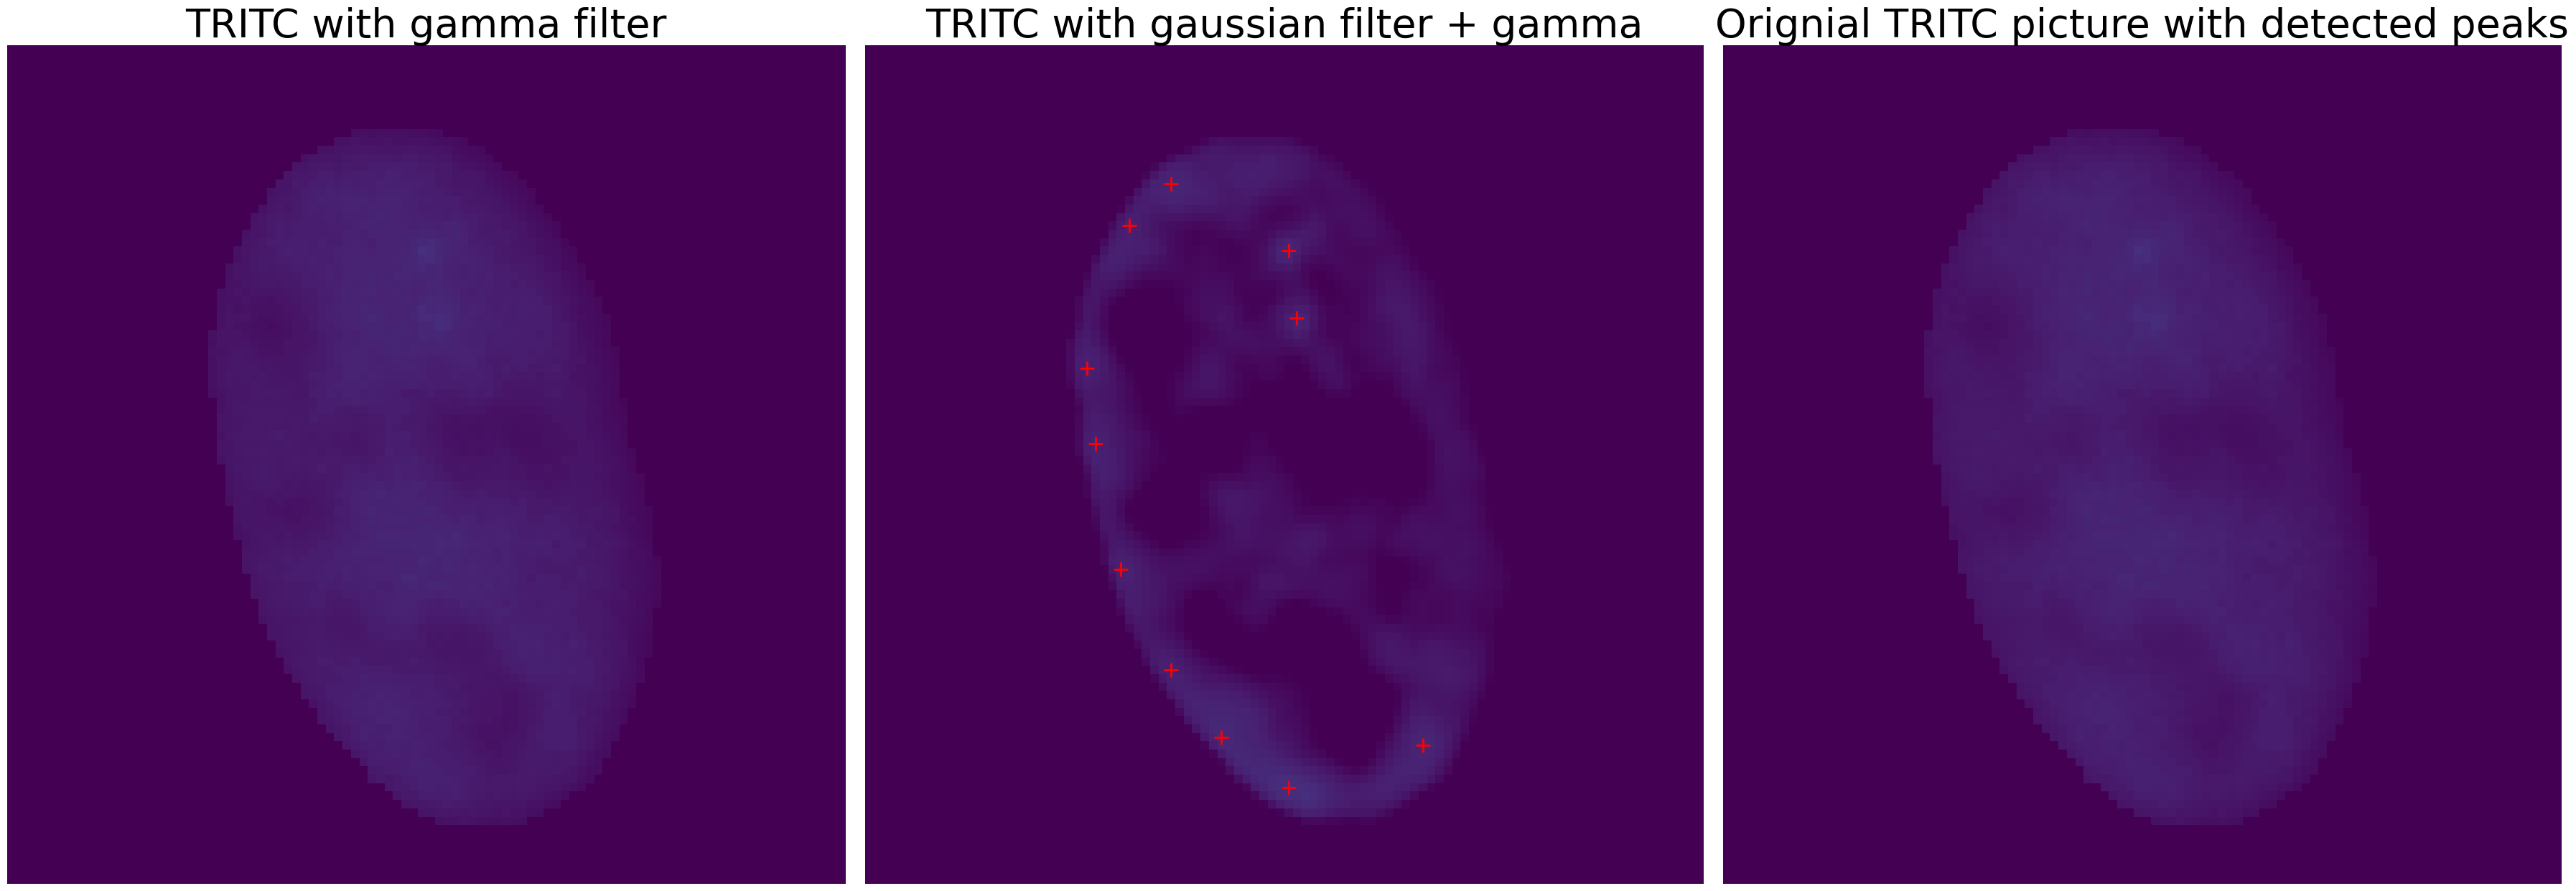

In [135]:
# Displaying the original picture with an isolated cell and the filtered picture
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36, 12))

# Finding the middle coordinates for the cell we want to look at
props = regionprops(masks_reduced.astype(int))  # Calculate region properties (centroid, area, etc.) for the cell mask
if props:  # Check if any regions (props) were found in the mask
    centroid_y, centroid_x = props[0].centroid  # Extract y and x coordinates of the cell's center, which is the only region (props[0])

# To stop the possibility of going out of boundary
if int(centroid_y) < 50:
    centroid_y = 50
if int(centroid_x) < 50:
    centroid_x = 50

# Initial crop
origin = ((int(centroid_y)-50),(int(centroid_x)-50))
#origin = (0,0)
size = (100,100) #~100x100 for single cell
#size = (2048,2048)


# Original TRITC Picture with isolated cell
axes[0].imshow(isolated_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]], vmin=0, vmax=TRITC_pic.max())

####################### Made by AI ###################################
# Adjust coordinates relative to the cropped region
adjusted_unfiltered = coordinates_unfiltered - origin
# Filter to only show peaks within the cropped region
mask = (adjusted_unfiltered[:, 0] >= 0) & (adjusted_unfiltered[:, 0] < size[0]) & \
       (adjusted_unfiltered[:, 1] >= 0) & (adjusted_unfiltered[:, 1] < size[1])
visible_unfiltered = adjusted_unfiltered[mask]

# Plot the peaks
axes[0].plot(visible_unfiltered[:, 1], visible_unfiltered[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[0].axis('off')
axes[0].set_title('TRITC with gamma filter', fontsize = 40)

# Filtered TRITC picture with isolated cell
axes[1].imshow(filtered_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]], vmin=0, vmax=TRITC_pic.max()) 

####################### Made by AI ###################################
# Adjust coordinates relative to the cropped region
adjusted_filtered = coordinates_filtered - origin
# Filter to only show peaks within the cropped region
mask = (adjusted_filtered[:, 0] >= 0) & (adjusted_filtered[:, 0] < size[0]) & \
       (adjusted_filtered[:, 1] >= 0) & (adjusted_filtered[:, 1] < size[1])
visible_filtered = adjusted_filtered[mask]

# Plot the peaks
axes[1].plot(visible_filtered[:, 1], visible_filtered[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[1].axis('off')
axes[1].set_title('TRITC with gaussian filter + gamma', fontsize = 40)

# Original TRITC Picture with isolated cell
axes[2].imshow(isolated_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]], vmin=0, vmax=TRITC_pic.max())

####################### Made by AI ###################################
# Adjust coordinates relative to the cropped region
adjusted_coords = coordinates - origin
# Filter to only show peaks within the cropped region
mask = (adjusted_coords[:, 0] >= 0) & (adjusted_coords[:, 0] < size[0]) & \
       (adjusted_coords[:, 1] >= 0) & (adjusted_coords[:, 1] < size[1])
visible_coords = adjusted_coords[mask]

# Plot the peaks
axes[2].plot(visible_coords[:, 1], visible_coords[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[2].axis('off')
axes[2].set_title('Orignial TRITC picture with detected peaks', fontsize = 40)

plt.tight_layout()
plt.show()

In [128]:
import numpy as np
import cv2
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel

threshold = foci_threshold_unfilt * 1

markers = np.zeros_like(filtered_TRITC, dtype=int)  # creates an array with the same shape and size as isolated_TRITC but all zeros
for i, (x, y) in enumerate(coordinates, start=1):  
    markers[x, y] = i  # gives the previously created zero array a number at the point of the foci coordinates

# To keep all the individual foci when expanding, they are expanded individually
markers_expanded = np.zeros_like(filtered_TRITC, dtype=int)
for i in range (markers.max()):
    label = i+1
    single_marker = (markers == label)
    markers_dilated = ndi.binary_dilation(single_marker, iterations=1) #  dilates the foci spots for X iterations
    markers_expanded[markers_dilated] = label  

distance = ndi.distance_transform_edt(filtered_TRITC < threshold)  # calculates Distance to the nearest background

gradient = sobel(filtered_TRITC)


labels = watershed(gradient, markers_expanded, mask=(filtered_TRITC > threshold))  # Applying Watershed, -distance to invert map height map (to make peaks to valleys)


# To get all the data from the watershed
for region_id in range(1, markers.max() + 1):
    spot_mask = (labels == region_id)
    spot_area = np.sum(spot_mask)
    spot_intensity = np.sum(isolated_TRITC[spot_mask])





<function matplotlib.pyplot.show(close=None, block=None)>

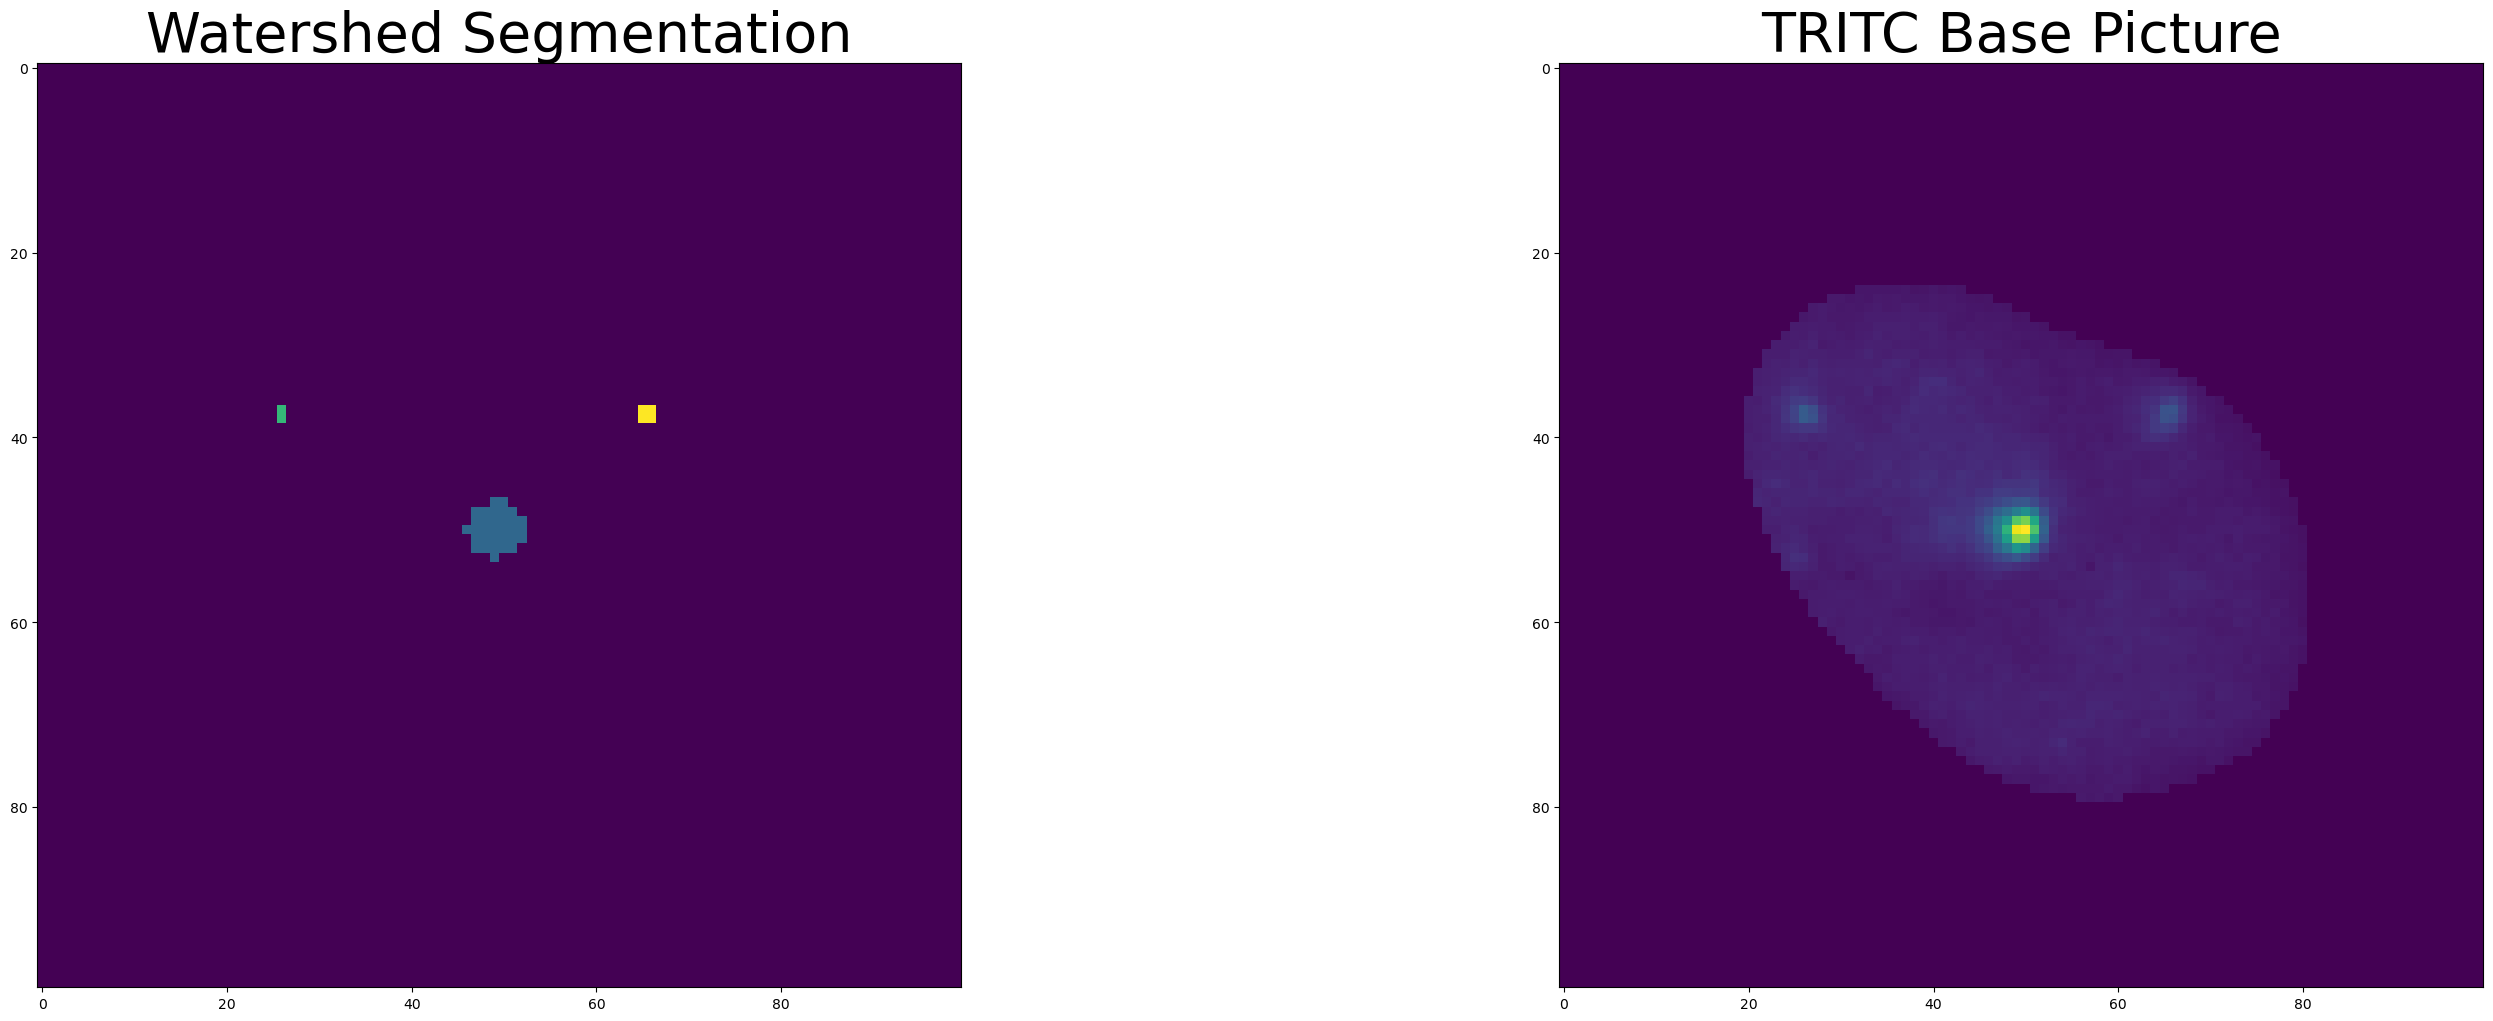

In [129]:
# Displaying the original picture with an isolated cell and the filtered picture
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(36, 12))

# Finding the middle coordinates for the cell we want to look at
props = regionprops(masks_reduced.astype(int))  # Calculate region properties (centroid, area, etc.) for the cell mask
if props:  # Check if any regions (props) were found in the mask
    centroid_y, centroid_x = props[0].centroid  # Extract y and x coordinates of the cell's center, which is the only region (props[0])

# To stop the possibility of going out of boundary
if int(centroid_y) < 50:
    centroid_y = 50
if int(centroid_x) < 50:
    centroid_x = 50

# Initial crop
origin = ((int(centroid_y)-50),(int(centroid_x)-50))
#origin = (0,0)
size = (100,100) #~100x100 for single cell
#size = (2048,2048)






# Show the watershed labels as colored regions
axes[0].imshow(labels[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]])
axes[0].set_title('Watershed Segmentation', fontsize = 40)


axes[1].imshow(isolated_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]])
axes[1].set_title('TRITC Base Picture', fontsize = 40)

plt.show

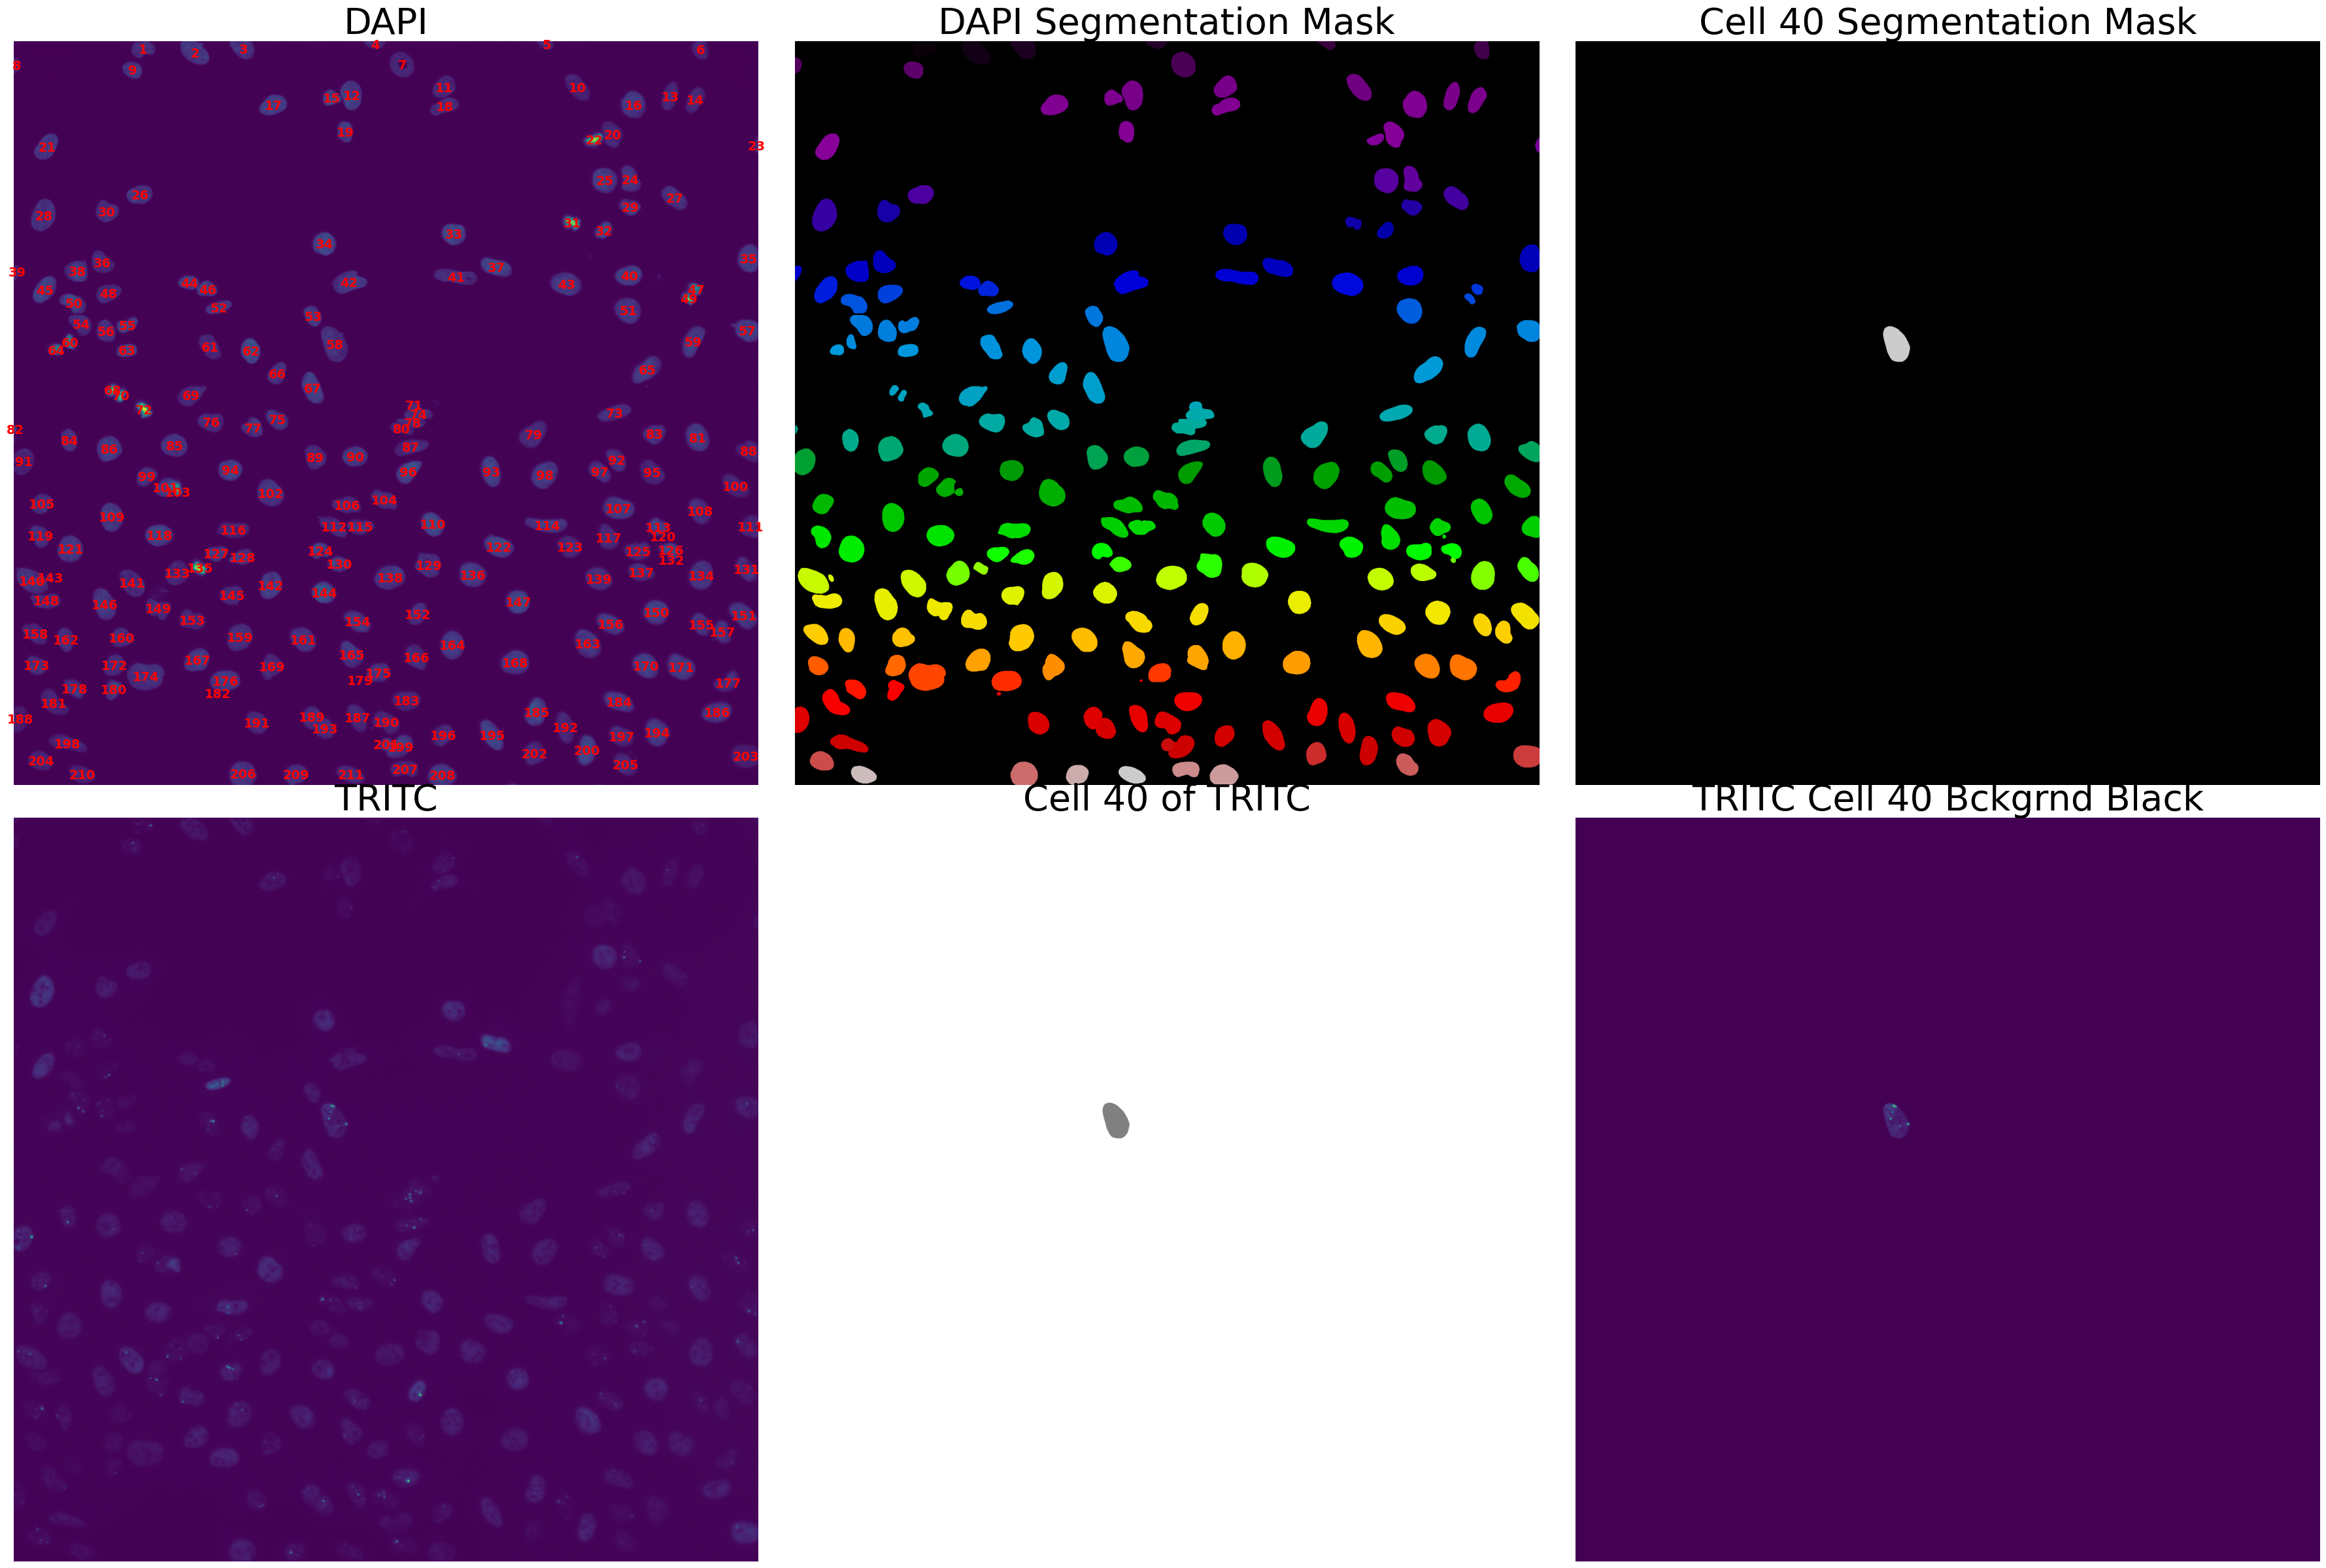

In [36]:
# Plotting Masks
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(36, 24))

# Original DAPI Picture
axes[0,0].imshow(DAPI_pic)

# Adding numbers to the Individual nuclei to identify them easier
nums = regionprops(masks)
for prop in nums:
    #Getting the coordinates of the center of the nuclei
    y, x = prop.centroid  # getting the x and y coordinates
    label = prop.label   # getting the number of the nucleus at that position

    # Adding the text at the location of the centroids
    axes[0,0].text(x, y, str(label), color = 'red', fontsize = 14, ha = 'center', va = 'center', weight = 'bold')

axes[0,0].axis('off')
axes[0,0].set_title('DAPI', fontsize = 40)

# Full Segmentation Mask
axes[0,1].imshow(masks, cmap='nipy_spectral') 
axes[0,1].axis('off')
axes[0,1].set_title('DAPI Segmentation Mask', fontsize = 40)

# Singular Nucleus isolated from Mask
axes[0,2].imshow(masks_reduced, cmap='nipy_spectral')
axes[0,2].axis('off')
axes[0,2].set_title('Cell 40 Segmentation Mask', fontsize = 40)

# Original TRITC Picture
axes[1,0].imshow(TRITC_pic)
axes[1,0].axis('off')
axes[1,0].set_title('TRITC', fontsize = 40)

# Mask overlaying the TRITC Picture
axes[1,1].imshow(masked_TRITC, cmap='nipy_spectral', alpha=0.5)
axes[1,1].axis('off')
axes[1,1].set_title('Cell 40 of TRITC', fontsize = 40)

#show TRITC with applied mask
axes[1,2].imshow(isolated_TRITC)
axes[1,2].axis('off')
axes[1,2].set_title('TRITC Cell 40 Bckgrnd Black', fontsize = 40)

plt.tight_layout()
plt.show()